In [1]:
import importlib
import re
import glob
from torchvision import transforms, datasets
from load_data import FrequencyDataset, GreyToColorDataset
import plots
import numpy as np
from utils import convert_tb_data, SCRATCH_PATH, REPO_ROOT, load_pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import itertools
# plots = importlib.reload()
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
importlib.reload(plots)

<module 'plots' from '/Users/alecflowers/Documents/EPFL/2022_spring/dynamic_poly_nn/plots.py'>

## Ensemble Metrics

In [3]:
path = "./scratch/logs/ensemble"
name = "results_1.pkl"
name2 = "results_2.pkl"
model_df = load_pickle(path, name2)
model_df2 = load_pickle(path, name)

In [51]:
model_list = ['NCPS_ensemble_low', "NCPS_ensemble_mid1", "NCPS_ensemble_mid2", "NCPS_ensemble_high", "ensemble_pred"]
for m in model_list:
    print(f"{m}: {model_df[model_df[m] == model_df['y_true']].shape[0] / model_df.shape[0]}")

NCPS_ensemble_low: 0.4214
NCPS_ensemble_mid1: 0.4292
NCPS_ensemble_mid2: 0.4336
NCPS_ensemble_high: 0.4308
ensemble_pred: 0.5121


In [53]:
model_list = ["model_0", "model_1", "model_2", "model_3", "ensemble_pred"]
for m in model_list:
    print(f"{m}: {model_df2[model_df2[m] == model_df2['y_true']].shape[0] / model_df2.shape[0]}")

model_0: 0.4597
model_1: 0.4758
model_2: 0.4277
model_3: 0.4114
ensemble_pred: 0.5472


In [4]:
model_df['model_4'] = model_df2['model_0']
model_df['model_4_softmax'] = model_df2['model_0_softmax']

model_df['model_5'] = model_df2['model_1']
model_df['model_5_softmax'] = model_df2['model_1_softmax']

model_df['model_6'] = model_df2['model_2']
model_df['model_6_softmax'] = model_df2['model_2_softmax']

model_df['model_7'] = model_df2['model_3']
model_df['model_7_softmax'] = model_df2['model_3_softmax']

In [5]:
def calc_angle(x, y):
    # shift axis
    x = 1 - x
    y = 1 - y
    theta = np.arctan(x / y)
    angle = np.degrees(theta - np.pi/4)
    
    return angle

In [6]:
from itertools import combinations
for i in combinations([0, 1, 2, 3, 4, 5, 6, 7], r=2):
    model_df[f'angle_{i[0]}_{i[1]}'] = model_df.apply(lambda x: calc_angle(x[f'model_{i[0]}_softmax'], x[f'model_{i[1]}_softmax']), axis=1)

In [7]:
def plot_histograms(model_1, model_2, model_num):
    angle = f'angle_{model_num[0]}_{model_num[1]}'
    both_correct = model_df[(model_df[model_2] == model_df['y_true']) & (model_df[model_1] == model_df['y_true'])][angle]
    both_incorrect = model_df[~((model_df[model_2] == model_df['y_true']) & (model_df[model_1] == model_df['y_true']))][angle]
    only_one_correct = model_df[(model_df[model_1] == model_df['y_true'])][angle]
    only_other_correct = model_df[(model_df[model_2] == model_df['y_true'])][angle]

    fig, ax = plt.subplots(2,2,figsize=(12,8), sharex=True, sharey=True)
    ax[0,0].set_title('Both Correct')
    ax[0,1].set_title('Both Incorrect')
    ax[1,0].set_title('Model 1 Correct')
    ax[1,1].set_title('Model 2 Correct')
    sns.histplot(both_correct, ax=ax[0,0])
    sns.histplot(both_incorrect, ax=ax[0,1])
    sns.histplot(only_one_correct, ax=ax[1,0])
    sns.histplot(only_other_correct, ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
def plot_angles(model_1, model_2, model_num):
    angle = f'angle_{model_num[0]}_{model_num[1]}'
    one_correct = model_df[model_df[model_1] == model_df['y_true']]
    other_correct = model_df[model_df[model_2] == model_df['y_true']]
    one_only_correct = model_df[(model_df[model_1] == model_df['y_true']) & ~(model_df[model_2] == model_df['y_true'])]
    other_only_correct = model_df[~(model_df[model_1] == model_df['y_true']) & (model_df[model_2] == model_df['y_true'])]

    fig, ax = plt.subplots(2,2,figsize=(12,8), sharex=True, sharey=True)
    ax[0,0].set_title('Model 1 Correct')
    ax[0,1].set_title('Model 2 Correct')
    ax[1,0].set_title('Model 1 Correct, Model 2 Incorrect')
    ax[1,1].set_title('Model 2 Correct, Model 1 Incorrect')
    sns.scatterplot(x=angle, y= 'y_true', data = one_correct, ax=ax[0,0])
    sns.scatterplot(x=angle, y= 'y_true', data = other_correct, ax=ax[0,1])
    sns.scatterplot(x=angle, y= 'y_true', data = one_only_correct, ax=ax[1,0])
    sns.scatterplot(x=angle, y= 'y_true', data = other_only_correct, ax=ax[1,1])
    plt.tight_layout()
    plt.show()

In [8]:
model_df.head(1)

,NCPS_ensemble_low,NCPS_ensemble_high,NCPS_ensemble_mid2,NCPS_ensemble_mid1,model_0_softmax,model_1_softmax,model_2_softmax,model_3_softmax,y_true,ensemble_pred,...,angle_3_4,angle_3_5,angle_3_6,angle_3_7,angle_4_5,angle_4_6,angle_4_7,angle_5_6,angle_5_7,angle_6_7
0,95,68,95,90,0.029759,0.019113,0.006101,0.033504,49,68,...,2.150408,0.535073,-0.128386,-0.214945,-1.616468,-2.278411,-2.364688,-0.663431,-0.749966,-0.086561


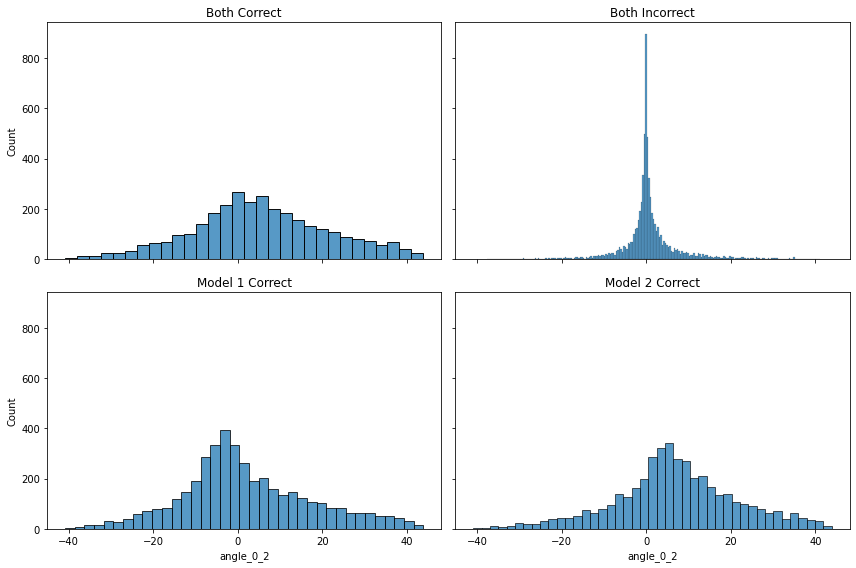

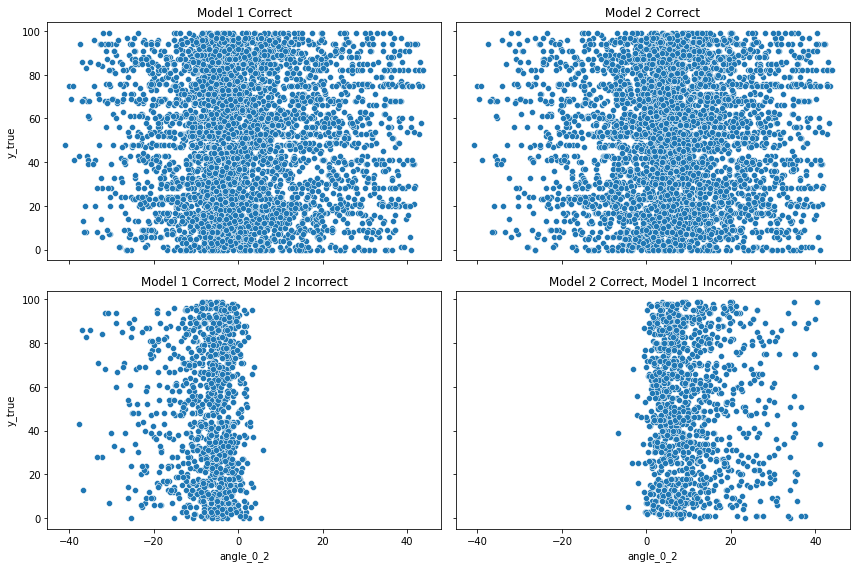

In [9]:
model_1 = 'NCPS_ensemble_low'
model_2 = 'NCPS_ensemble_mid2'
angle = (0, 2)

plot_histograms(model_1, model_2, angle)
plot_angles(model_1, model_2, angle)

In [37]:
colors=  {
    0: 'indianred',
    1: 'forestgreen',
    2: 'darkviolet',
    3: 'wheat'
}

def create_ensemble_plots(plot, label, save=False):
    sns.set_style("white")
    sns.set_context("notebook")
    sns.despine()
    fig, ax = plt.subplots(2,2,figsize=(12,8),)

    both_correct = []
    for m in plot:
        angle = f'angle_{m[2][0]}_{m[2][1]}'
        both_correct.append(model_df[(model_df[m[1]] == model_df['y_true']) & (model_df[m[0]] == model_df['y_true'])][angle])
    for i, data in enumerate(both_correct):
        sns.histplot(data, bins=60 ,color=colors[i], legend=True, ax=ax[0,0], label=label[i], alpha=0.9 - (.3 * i))
        ax[0,0].legend(loc="upper left", bbox_to_anchor=(-.7, 1))

    both_incorrect = []
    for m in plot:
        angle = f'angle_{m[2][0]}_{m[2][1]}'
        both_incorrect.append(model_df[~((model_df[m[1]] == model_df['y_true']) & (model_df[m[0]] == model_df['y_true']))][angle])
    for i, data in enumerate(both_incorrect):
        sns.histplot(data, bins=60, color=colors[i], ax=ax[0,1], alpha=0.9 - (.3 * i))

    only_one_correct = []
    for m in plot:
        angle = f'angle_{m[2][0]}_{m[2][1]}'
        only_one_correct.append(model_df[(model_df[m[0]] == model_df['y_true'])][angle])
    for i, data in enumerate(only_one_correct):
        sns.histplot(data, bins=60, color=colors[i], ax=ax[1,0], alpha=0.9 - (.3 * i))

    only_other_correct = []
    for m in plot:
        angle = f'angle_{m[2][0]}_{m[2][1]}'
        only_other_correct.append(model_df[(model_df[m[1]] == model_df['y_true'])][angle])
    for i, data in enumerate(only_other_correct):
        sns.histplot(data, bins=60, color=colors[i], ax=ax[1,1], alpha=0.8 - (.3 * i))

    for i in range(4):
        ax[i//2,i%2].set_xlabel('theta')
        ax[i//2,i%2].text(-50, -.15*ax[i//2,i%2].get_ylim()[1], 'Model 2 Confident')
        ax[i//2,i%2].text(20, -.15*ax[i//2,i%2].get_ylim()[1], 'Model 1 Confident')

    ax[0,0].set_title('Both Models Correct')
    ax[0,1].set_title('Neither Models Correct')
    ax[1,0].set_title('Only Model 2 Correct')
    ax[1,1].set_title('Only Model 1 Correct')
    plt.tight_layout()
    if save:
        plt.savefig("ensemble_fig.png")
    plt.show()

<Figure size 432x288 with 0 Axes>

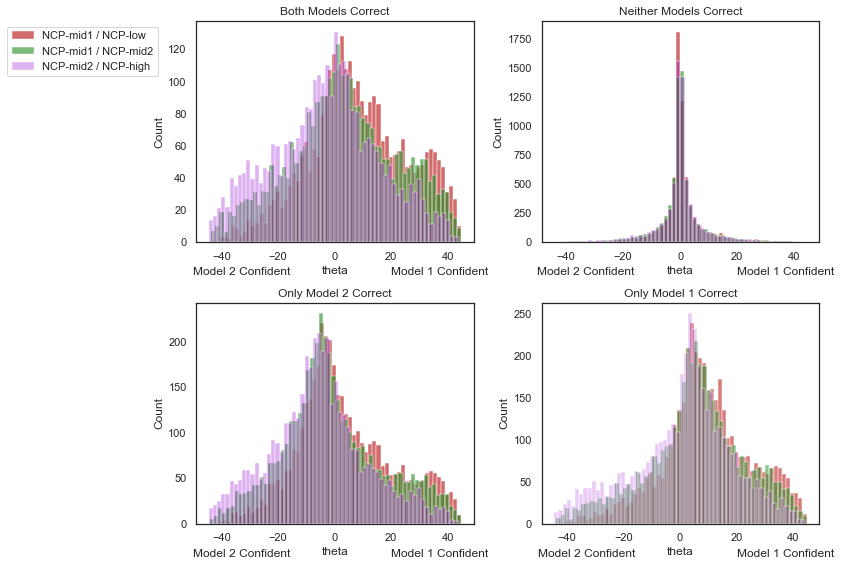

In [54]:
# The model that is second here is Model 1 in the plot & is on the right side
plot = [
    ("NCPS_ensemble_low", "NCPS_ensemble_mid1", (0,3)),
    ("NCPS_ensemble_mid2", "NCPS_ensemble_mid1", (2,3)),
    ("NCPS_ensemble_high", "NCPS_ensemble_mid2", (1,2))
]
label = {
    0: "NCP-mid1 / NCP-low",
    1: "NCP-mid1 / NCP-mid2",
    2: "NCP-mid2 / NCP-high",
}
create_ensemble_plots(plot, label, save=True)

<Figure size 432x288 with 0 Axes>

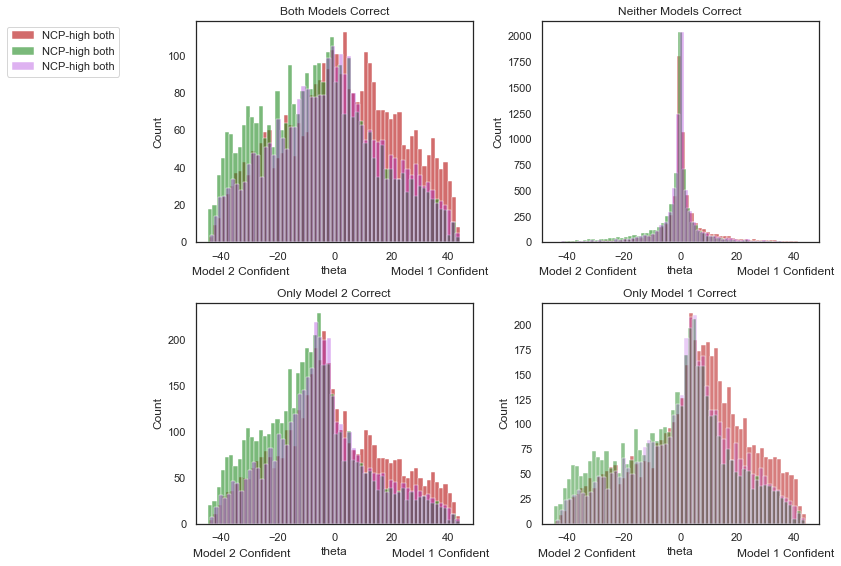

In [39]:
plot = [
    ("model_4", "model_5", (4,5)),
    ("model_5", "model_6", (5,6)),
    ("model_6", "model_7", (6,7))
]
label = {
    0: "NCP-high both",
    1: "NCP-high both",
    2: "NCP-high both",
}
create_ensemble_plots(plot, label, save=True)

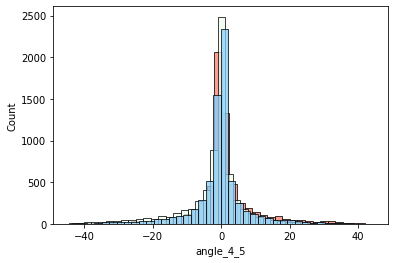

In [79]:
both_incorrect = []
for m in plot:
    angle = f'angle_{m[2][0]}_{m[2][1]}'
    both_incorrect.append(model_df[~((model_df[m[1]] == model_df['y_true']) & (model_df[m[0]] == model_df['y_true']))][angle])
for i, data in enumerate(both_incorrect):
    sns.histplot(data, bins=40, color=colors[i])

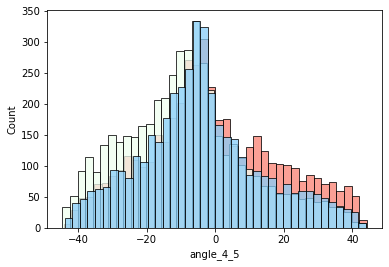

In [80]:
only_one_correct = []
for m in plot:
    angle = f'angle_{m[2][0]}_{m[2][1]}'
    only_one_correct.append(model_df[(model_df[m[0]] == model_df['y_true'])][angle])
for i, data in enumerate(only_one_correct):
    sns.histplot(data, bins=40, color=colors[i])

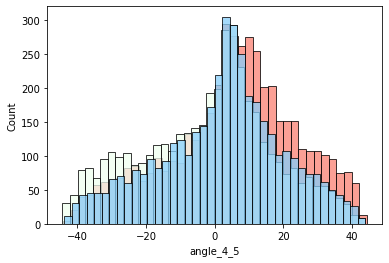

In [81]:
only_other_correct = []
for m in plot:
    angle = f'angle_{m[2][0]}_{m[2][1]}'
    only_other_correct.append(model_df[(model_df[m[1]] == model_df['y_true'])][angle])
for i, data in enumerate(only_other_correct):
    sns.histplot(data, bins=40, color=colors[i])

## Learning Data in Order

In [2]:
#To load from pickle file
def load_data_pickle(paths):
    data_list = []
    for idx, path in enumerate(paths):
        data = []
        i = 0
        with open(path, 'rb') as fr:
            try:
                while i <= 15:
                    data.append(pickle.load(fr))
                    i+=1
            except EOFError:
                pass
            print(f'Data Loaded: {idx}')
        data_list.append(data)
    return data_list

def create_dataframe(data):
    [data[0].update(i) for i in data[1:]]
    return pd.DataFrame(data[0])

def correction(df):
    return df.eq(df['correct'], axis='rows').astype(int)

def create_null_data(df):
    mock_data =[]
    for i in df.drop('correct', axis=1).mean(axis=0).values:
        mock_data.append(np.random.binomial(1, i, size=(df.shape[0],)))

    return pd.DataFrame(mock_data).transpose()

def calculate_tp_agreement(data_list):
    first = create_dataframe(data_list[0])
    old_df = correction(first)
    old_df_mock = create_null_data(old_df)

    for d in data_list[1:]:
        df = create_dataframe(d)
        df_correct = correction(df)
        df_correct_mock = create_null_data(df_correct)
        old_df = old_df.add(df_correct).astype(int)
        old_df_mock = old_df_mock.add(df_correct_mock).astype(int)

    tp_agreement = old_df / len(data_list)
    tp_agreement_mock = old_df_mock / len(data_list)

    return tp_agreement, tp_agreement_mock

In [19]:
def heatmap(tp_agreement, tp_agreement_mock, title='Poly Nets (2 and 6 degree)'):
    tp_agreement_heatmap = tp_agreement.drop('correct', axis=1).apply(pd.Series.value_counts, ascending=True)
    tp_agreement_mock_heatmap = tp_agreement_mock.apply(pd.Series.value_counts, ascending=True)

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.heatmap(tp_agreement_heatmap, cbar=True, ax=ax, cmap="Blues", cbar_kws={'spacing':'proportional'})
    ax.invert_yaxis()
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=16)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Tp-agreement')
    plt.show()

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.heatmap(tp_agreement_mock_heatmap, cbar=True, ax=ax, cmap="YlOrBr", cbar_kws={'spacing':'proportional'})
    ax.invert_yaxis()
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=16)
    plt.title('Null Hypothesis Data')
    plt.xlabel('Epochs')
    plt.ylabel('Tp-agreement')
    plt.show()

In [28]:
paths = list(filter(
        lambda x: not re.search('xxxx', x),
        glob.glob(f"{SCRATCH_PATH}/logs/FashionMNIST/CCP_n*/valid_accuracy_list.pkl", recursive=True)
    ))
print(paths)
print(len(paths))

['/Users/alecflowers/Documents/EPFL/2022_spring/dynamic_poly_nn/scratch/logs/FashionMNIST/CCP_non_poly_agree_d2_s4_20220504-180855/valid_accuracy_list.pkl', '/Users/alecflowers/Documents/EPFL/2022_spring/dynamic_poly_nn/scratch/logs/FashionMNIST/CCP_non_poly_agree_d6_s3_20220504-180053/valid_accuracy_list.pkl', '/Users/alecflowers/Documents/EPFL/2022_spring/dynamic_poly_nn/scratch/logs/FashionMNIST/CCP_non_poly_agree_d6_s4_20220504-180053/valid_accuracy_list.pkl', '/Users/alecflowers/Documents/EPFL/2022_spring/dynamic_poly_nn/scratch/logs/FashionMNIST/CCP_non_poly_agree_d2_s3_20220504-180855/valid_accuracy_list.pkl', '/Users/alecflowers/Documents/EPFL/2022_spring/dynamic_poly_nn/scratch/logs/FashionMNIST/CCP_non_poly_agree_d2_s2_20220504-180855/valid_accuracy_list.pkl', '/Users/alecflowers/Documents/EPFL/2022_spring/dynamic_poly_nn/scratch/logs/FashionMNIST/CCP_non_poly_agree_d6_s5_20220504-180053/valid_accuracy_list.pkl', '/Users/alecflowers/Documents/EPFL/2022_spring/dynamic_poly_nn/

In [29]:
data_list = load_data_pickle(paths)
tp, mock_tp = calculate_tp_agreement(data_list)

Data Loaded: 0
Data Loaded: 1
Data Loaded: 2
Data Loaded: 3
Data Loaded: 4
Data Loaded: 5
Data Loaded: 6
Data Loaded: 7
Data Loaded: 8
Data Loaded: 9
Data Loaded: 10
Data Loaded: 11
Data Loaded: 12
Data Loaded: 13
Data Loaded: 14
Data Loaded: 15


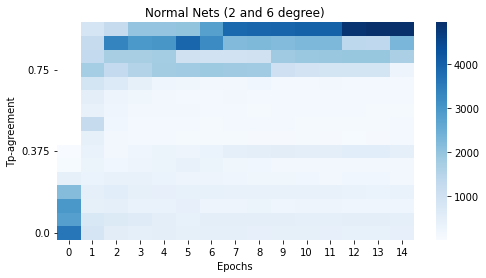

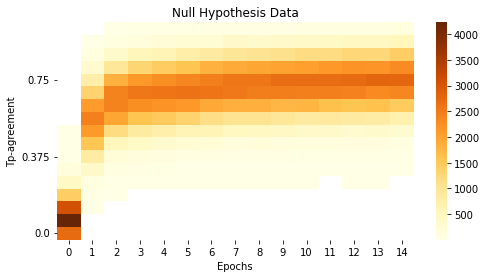

In [32]:
heatmap(tp, mock_tp, 'Normal Nets (2 and 6 degree)')

## Spectral Experiments

In [28]:
df = convert_tb_data(root_dir=f"{SCRATCH_PATH}/logs/CIFAR10")

In [117]:
def poly_label(x):
    if 'poly2' in x:
        return 2
    elif 'poly6' in x:
        return 6
    else:
        return 0

def radius_label(x):
    if any(s in x for s in ('low4','high4')):
        return 4
    elif any(s in x for s in ('low8','high8')):
        return 8
    elif any(s in x for s in ('low12','high12')):
        return 12
    elif any(s in x for s in ('low16','high16')):
        return 16
    else:
        return 0

In [126]:
def add_plotting(df):
    df['polynomial'] = df['run'].apply(lambda x: poly_label(x))
    df['radius'] = df['run'].apply(lambda x: radius_label(x))

In [127]:
df_low = df.loc[df['run'].str.contains('low') & ~df['run'].str.contains('baseline')]
df_high = df.loc[df['run'].str.contains('high') & ~df['run'].str.contains('baseline')]

In [128]:
df_low_acc_train = df_low.loc[df_low['name'].str.contains('Accuracy/Train')].copy()
df_low_acc_test = df_low.loc[df_low['name'].str.contains('Accuracy/Test')].copy()
df_low_loss_train = df_low.loc[df_low['name'].str.contains('Loss/Train')].copy()
df_low_loss_test = df_low.loc[df_low['name'].str.contains('Loss/Test')].copy()

In [129]:
add_plotting(df_low_acc_train)
add_plotting(df_low_acc_test)
add_plotting(df_low_loss_train)
add_plotting(df_low_loss_test)

In [130]:
sns.set_theme()
sns.color_palette('husl')
palette ={4: "C0", 8: "C1", 12: "C2", 16: "C3"}

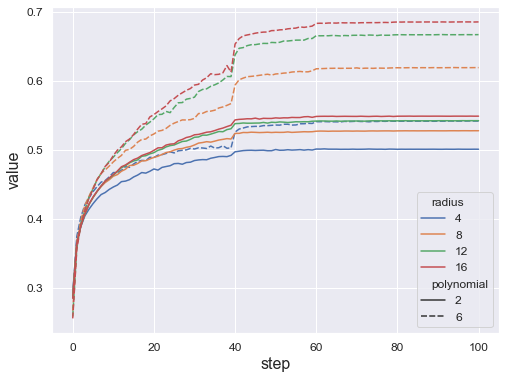

In [140]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)


plt.figure(figsize=(8, 6))
#plt.title('Low Frequency - Train Accuracy', fontsize=16)
sns.lineplot(x='step', y='value', hue='radius', style='polynomial', data = df_low_acc_train, palette=palette)
plt.show()
# plt.savefig("low_freq_train_acc.png")

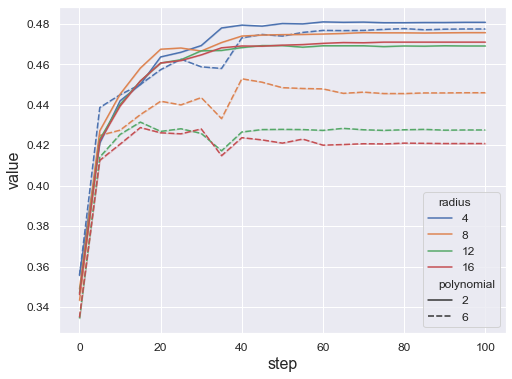

In [143]:
plt.figure(figsize=(8, 6))
# plt.title('Low Frequency - Valid Accuracy', fontsize=16)
sns.lineplot(x='step', y='value', hue='radius', style='polynomial', data = df_low_acc_test, palette=palette)
# plt.savefig("low_freq_valid_acc.png")
plt.show()

<AxesSubplot:title={'center':'Low Frequency - Train Loss'}, xlabel='step', ylabel='value'>

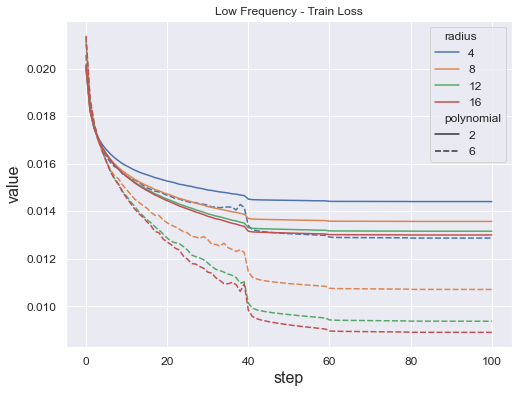

In [133]:
plt.figure(figsize=(8, 6))
plt.title('Low Frequency - Train Loss')
sns.lineplot(x='step', y='value', hue='radius', style='polynomial', data = df_low_loss_train, palette=palette)

<AxesSubplot:title={'center':'Low Frequency - Test Loss'}, xlabel='step', ylabel='value'>

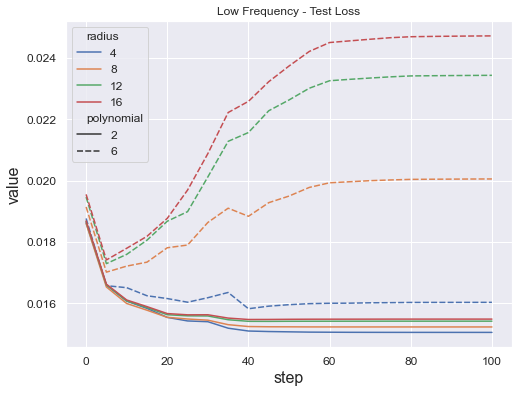

In [134]:
plt.figure(figsize=(8, 6))
plt.title('Low Frequency - Test Loss')
sns.lineplot(x='step', y='value', hue='radius', style='polynomial', data = df_low_loss_test, palette=palette)

In [135]:
df_high_acc_train = df_high.loc[df_high['name'].str.contains('Accuracy/Train')].copy()
df_high_acc_test = df_high.loc[df_high['name'].str.contains('Accuracy/Test')].copy()
df_high_loss_train = df_high.loc[df_high['name'].str.contains('Loss/Train')].copy()
df_high_loss_test = df_high.loc[df_high['name'].str.contains('Loss/Test')].copy()

In [136]:
add_plotting(df_high_acc_train)
add_plotting(df_high_acc_test)
add_plotting(df_high_loss_train)
add_plotting(df_high_loss_test)

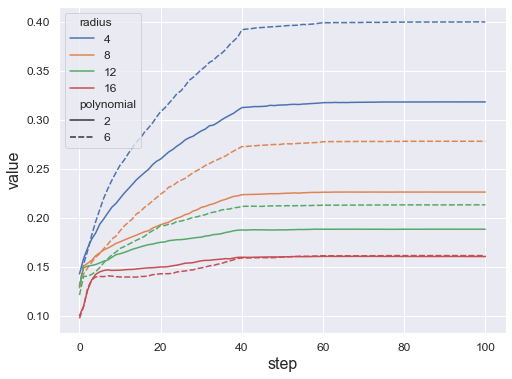

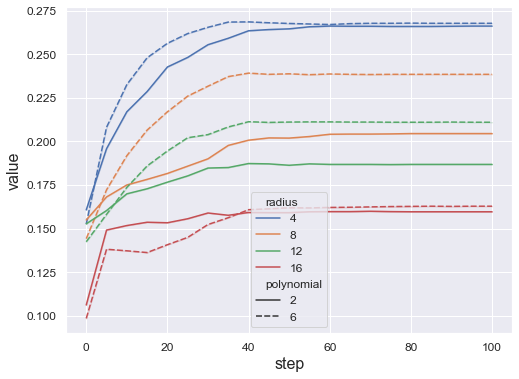

In [144]:
plt.figure(figsize=(8, 6))
#plt.title('High Frequency - Train Accuracy')
sns.lineplot(x='step', y='value', hue='radius', style='polynomial', data = df_high_acc_train, palette=palette)
plt.savefig("high_freq_train_acc.png")
plt.show()

plt.figure(figsize=(8, 6))
#plt.title('High Frequency - Test Accuracy')
sns.lineplot(x='step', y='value', hue='radius', style='polynomial', data = df_high_acc_test, palette=palette)
plt.savefig("high_freq_valid_acc.png")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('High Frequency - Train Loss')
sns.lineplot(x='step', y='value', hue='radius', style='polynomial', data = df_high_loss_train, palette=palette)
plt.show()

plt.figure(figsize=(8, 6))
plt.title('High Frequency - Test Loss')
sns.lineplot(x='step', y='value', hue='radius', style='polynomial', data = df_high_loss_test, palette=palette)
plt.show()

### Frequency Dataset Plot

In [157]:
root = './.data'
#transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
trainset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

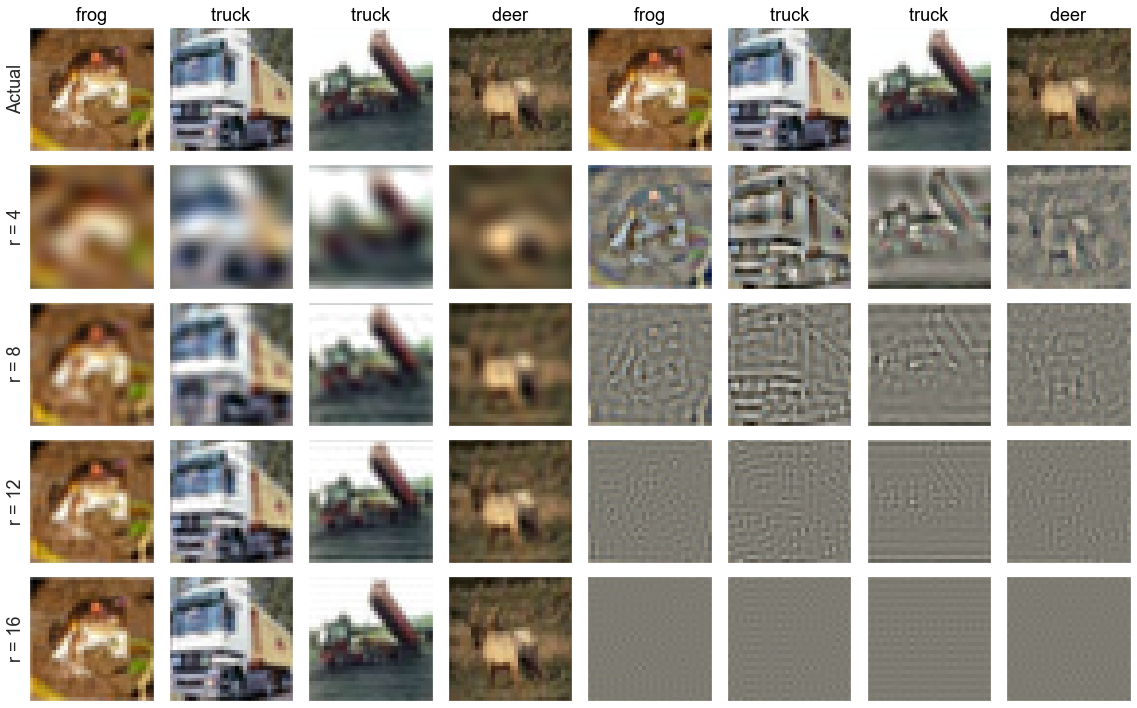

In [159]:
plt.figure(figsize=(16,10))
unorm = transforms.Normalize(mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010], std=[1/0.2023, 1/0.1994, 1/0.2010])
how = ['low', 'high']
radius = [4, 8, 12, 16]
dataset_list = []
for i, (r,h) in enumerate(itertools.product([0], ['high', 'high'])):
    img_list, label_list, mapping = plots.prepare_images(FrequencyDataset(trainset, r = r, how=h), np.arange(4), unorm=unorm)
    for j,im in enumerate(img_list):
        p = plt.subplot(
                5,
                8,
                i*4 + j + 1,
            )
        p.set_title(f"{label_list[j][4:]}", fontsize=18, color='black')
        plt.subplot(
                5,
                8,
                1,
            ).set_ylabel('Actual', fontsize=18)
        plt.subplot(5,8, i*4 + j + 1)
        plt.imshow(im, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

for i, (r,h) in enumerate(itertools.product(radius, how)):
    img_list, label_list, mapping = plots.prepare_images(FrequencyDataset(trainset, r = r, how=h), np.arange(4), unorm=unorm)
    for j,im in enumerate(img_list):
        plt.subplot(
            5,
            8,
            i*4 + j + 1 + 8,
        )
        plt.imshow(im, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

    plt.subplot(
            5,
            8,
            9,
        ).set_ylabel(f"r = {4}", fontsize=18)
    plt.subplot(
            5,
            8,
            17,
        ).set_ylabel(f"r = {8}", fontsize=18)
    plt.subplot(
            5,
            8,
            25,
        ).set_ylabel(f"r = {12}", fontsize=18)
    plt.subplot(
            5,
            8,
            33,
        ).set_ylabel(f"r = {16}", fontsize=18)
plt.tight_layout()
# plt.savefig("freq_samples.png", format="png")
plt.show()

## Spurious Correlation

In [2]:
root = './.data'
#transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
trainset = datasets.MNIST(root=root, train=True, download=True, transform=transform)

In [5]:
#unorm = transforms.Normalize((-0.5/0.5,), (1/0.5,))
img_list, label_list, mapping = plots.prepare_images(GreyToColorDataset(trainset), np.arange(100),)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

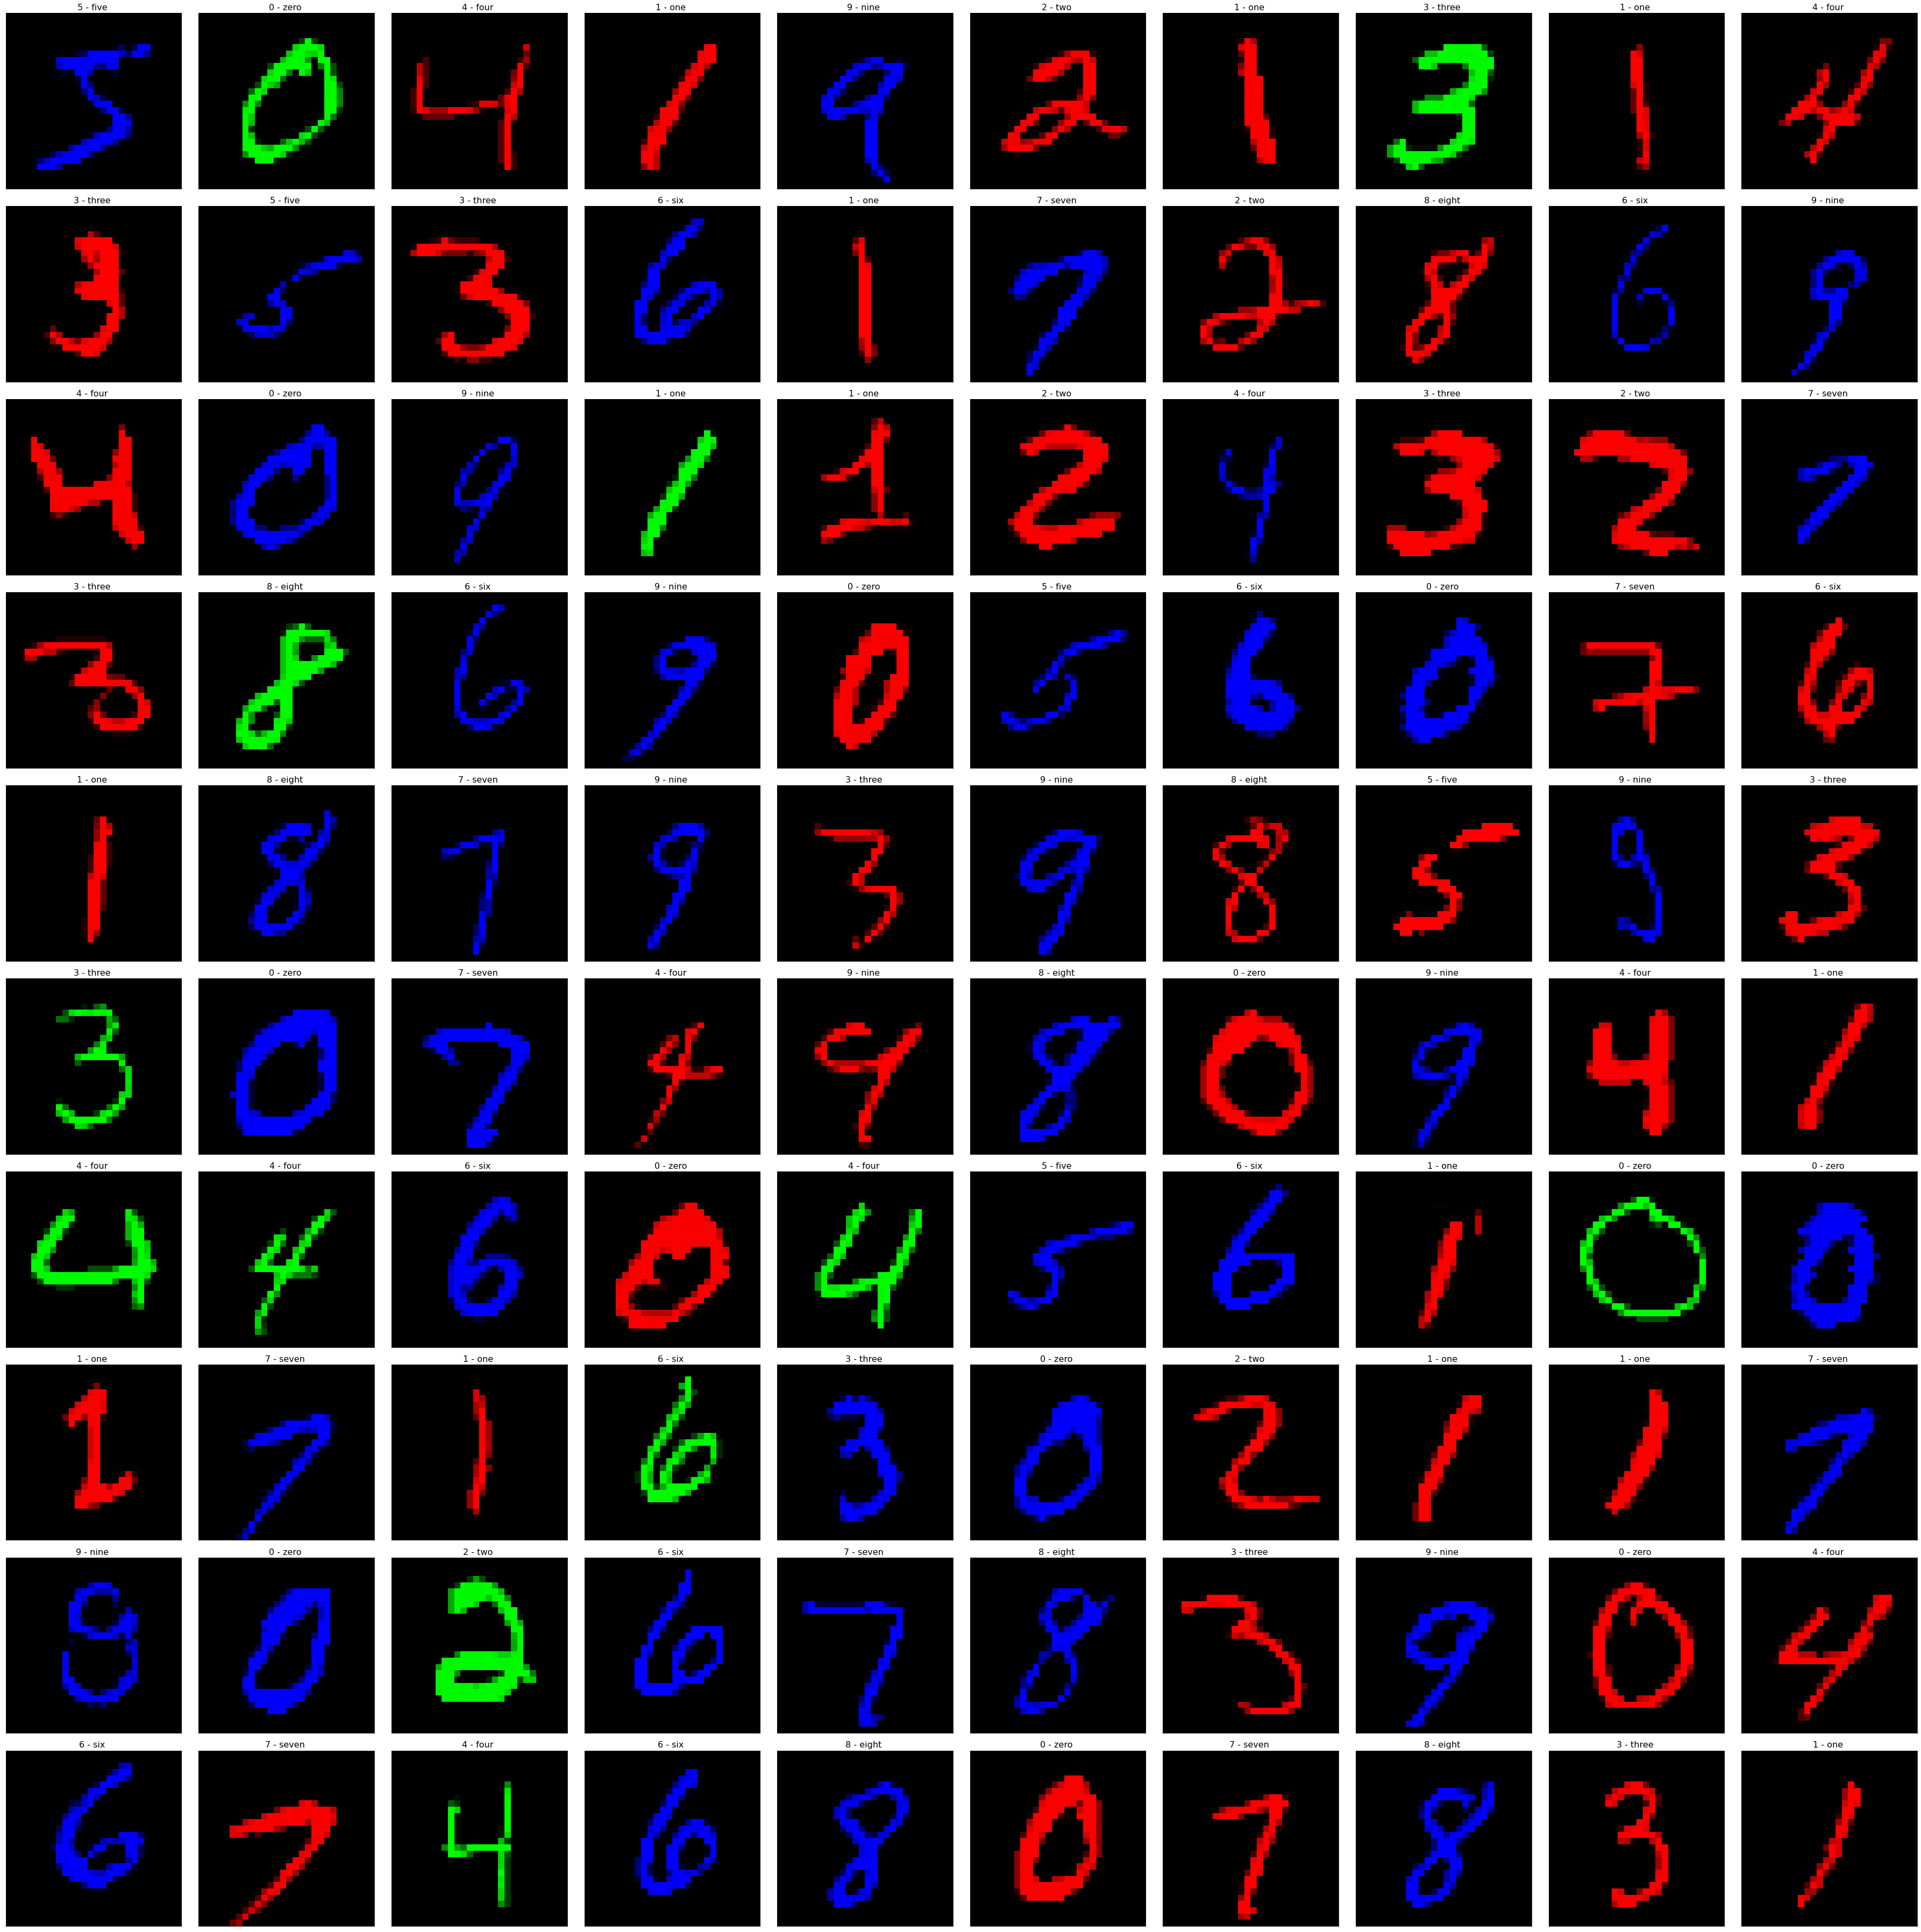

In [15]:
plots.plot_image_grid(img_list, subplot_title=label_list)

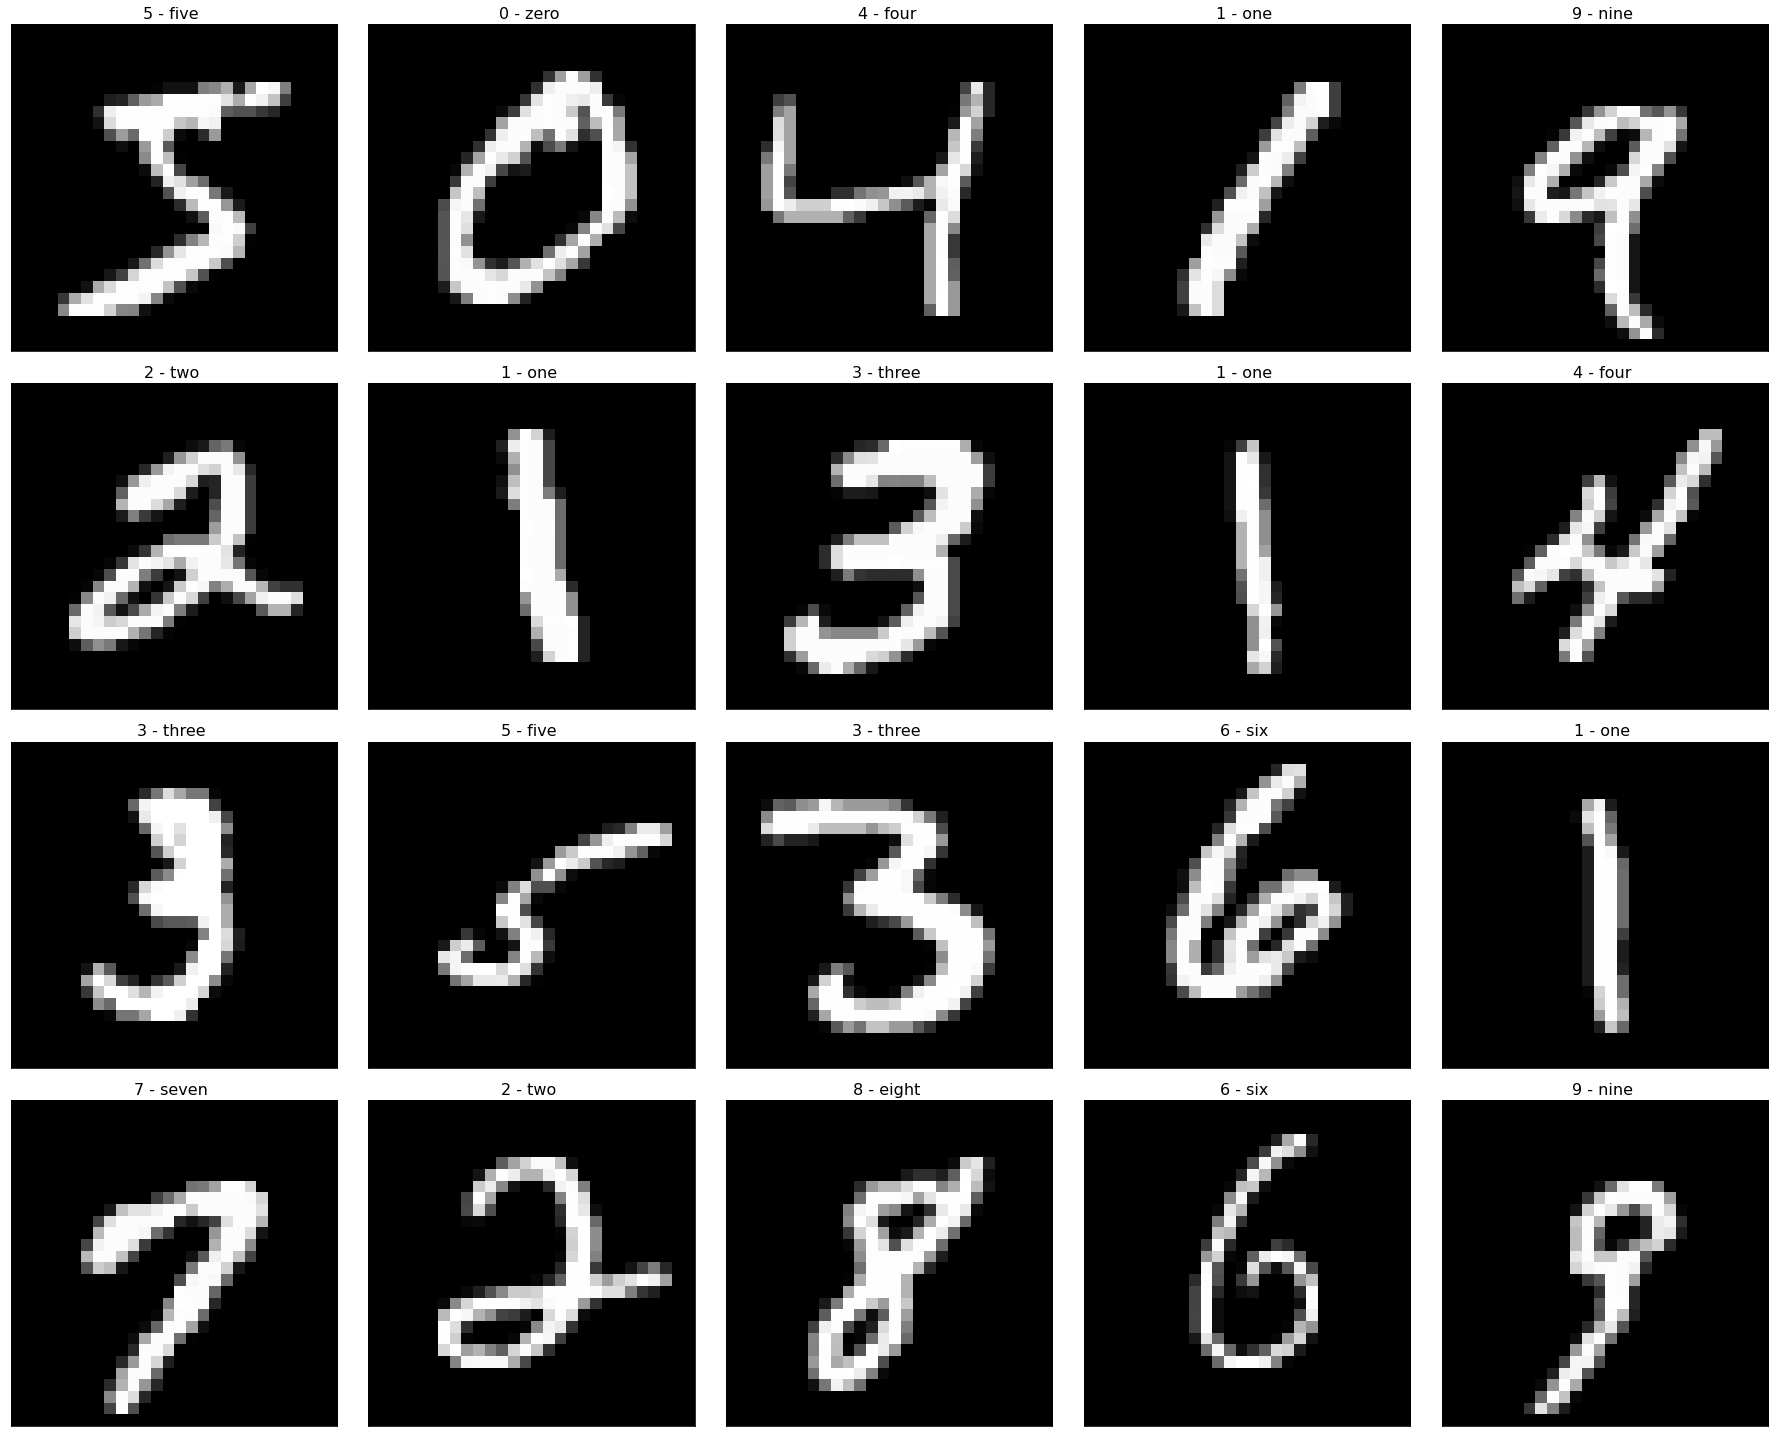

In [17]:
img_list_w, label_list_w, mapping = plots.prepare_images(trainset, np.arange(20),)
plots.plot_image_grid(img_list_w, subplot_title=label_list_w)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


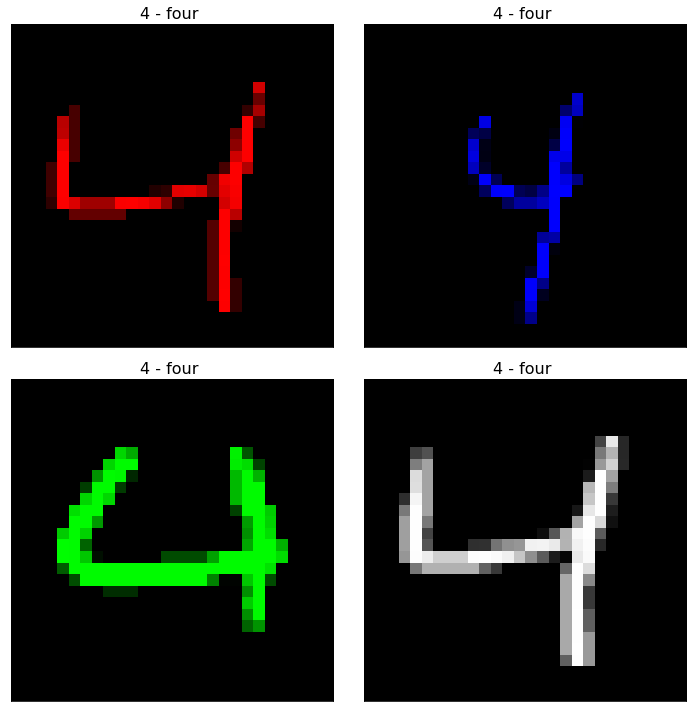

In [21]:
plots.plot_image_grid([img_list[2], img_list[26], img_list[60], img_list_w[2]], subplot_title=[label_list[2], label_list[26], label_list[60], label_list[60]], save=True)